In [252]:
import pandas as pd
import umap
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from scipy.spatial.distance import cosine
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib

In [253]:
embedding_df = pd.read_csv('./DataFolder/tensorboard/embedding/deep_emb.tsv', sep='\t', header=None)
metadata_df = pd.read_csv('./DataFolder/tensorboard/embedding/metadata.tsv', sep='\t', header=None)
# Trim embedding_df to match length of metadata_df
embedding_df = embedding_df.iloc[:len(metadata_df)]

In [254]:
def exclude_indices(matrix, indices):
    """
    Exclude rows from a matrix based on a list of indices.
    
    Parameters:
    - matrix: np.ndarray - The input matrix.
    - indices: list - List of row indices to exclude.
    
    Returns:
    - np.ndarray - Matrix with rows excluded.
    """
    all_indices = set(range(matrix.shape[0]))
    indices_to_keep = list(all_indices - set(indices))
    return matrix[indices_to_keep]

In [255]:
def is_inside_zoom_region(x, y, zoom_xlim, zoom_ylim):
    return zoom_xlim[0] <= x <= zoom_xlim[1] and zoom_ylim[0] <= y <= zoom_ylim[1]

In [256]:
reducer = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.5, metric='cosine', random_state=10)
embedding_2d = reducer.fit_transform(embedding_df)
mask = embedding_2d[:, 0] < 6
embedding_2d_filtered = embedding_2d[mask]
metadata_filtered_original_indices = metadata_df[mask]
metadata_filtered = metadata_filtered_original_indices.reset_index(drop=True)

In [257]:
# Compute pairwise distances in the 2D space
distances_2d = pairwise_distances(embedding_2d_filtered)
# Get the distances to the nearest neighbor for each point
min_distances = np.min(distances_2d + np.eye(distances_2d.shape[0]) * distances_2d.max(), axis=1)
# Sort indices based on the nearest neighbor distances in descending order
sorted_indices = np.argsort(-min_distances)
# Set to keep track of points excluded from labeling
excluded_indices = set()

# List to store the selected indices for labeling
label_indices = []

# Set exclusion radius
exclusion_radius = np.percentile(min_distances, 99.5)  # Adjust this value to control the spacing between labels

# Iterate over points in the order of sorted_indices
for idx in sorted_indices:
    if idx not in excluded_indices:
        label_indices.append(idx)
        # Exclude neighbors of the current point from labeling
        neighbors = np.where(distances_2d[idx] < exclusion_radius)[0]
        excluded_indices.update(neighbors)

In [258]:
# Identify the index of the point labeled "ten"
index_of_ten = metadata_filtered[metadata_filtered[0] == "meet"].index[0]
# Fit the NearestNeighbors on the entire original dataset
embedding_df_filtered = embedding_df.iloc[metadata_filtered_original_indices.index]

# Now, you can proceed with fitting the NearestNeighbors and other operations
nbrs_original = NearestNeighbors(n_neighbors=10, metric=cosine).fit(embedding_df_filtered)
_, neighbors_of_ten = nbrs_original.kneighbors(embedding_df_filtered.iloc[[index_of_ten]])
neighbors_of_ten = neighbors_of_ten.flatten()

/Users/jackwang/.local/share/virtualenvs/Code-_CZGGnvj/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackwang/.local/share/virtualenvs/Code-_CZGGnvj/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackwang/.local/share/virtualenvs/Code-_CZGGnvj/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackwang/.local/share/virtualenvs/Code-_CZGGnvj/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: Fut

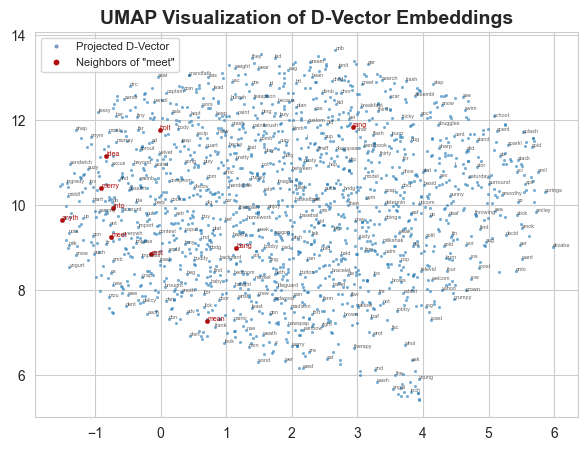

In [259]:
# Visualization using Seaborn
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)
excluded_point = exclude_indices(embedding_2d_filtered, neighbors_of_ten)

sns.scatterplot(x=excluded_point[:, 0], y=excluded_point[:, 1], alpha=0.6, edgecolor=None, s=4, ax=ax)
# Plot the neighbors of "ten" in red
sns.scatterplot(x=embedding_2d_filtered[neighbors_of_ten, 0], y=embedding_2d_filtered[neighbors_of_ten, 1], alpha=1, color=sns.dark_palette('red')[3], edgecolor=None, s=10, ax=ax)

# Adding labels for spaced out words
for i in label_indices:
    if i not in neighbors_of_ten:
        plt.annotate(metadata_filtered.iloc[i, 0], (embedding_2d_filtered[i, 0], embedding_2d_filtered[i, 1]), alpha=0.7, fontsize=4)

# Adding label neighbors of "ten"
for i in neighbors_of_ten:
    plt.annotate(metadata_filtered.iloc[i, 0], (embedding_2d_filtered[i, 0], embedding_2d_filtered[i, 1]), alpha=1, fontsize=5, color=sns.dark_palette('red')[3])
    
zoom_xlim = (-2, 0)
zoom_ylim = (-4, 0)

# ax.set_xticks([])
# ax.set_yticks([])

# Define dummy Line2D objects for the legend
circle1 = mlines.Line2D([], [], color=sns.color_palette("deep")[0], marker='o', markersize=4**0.5, linestyle='None', label='Projected D-Vector', alpha=0.6)
circle2 = mlines.Line2D([], [], color=sns.dark_palette('red')[3], marker='o', markersize=10**0.5, linestyle='None', label='Neighbors of "meet"', alpha=1)

ax.legend(handles=[circle1, circle2], loc='upper left', fontsize=8, frameon=True)
plt.title("UMAP Visualization of D-Vector Embeddings", fontsize=14, fontweight='bold')
plt.savefig('umap.pdf', format='pdf')

In [260]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots()
ax.plot([1, 2, 3, 4, 5], [1, 2, 3, 4, 5])

# Create inset of width 1 inch and height 1 inch at the upper right corner of the main axes
axins = inset_axes(ax, width=1, height=1, loc=1)
axins.plot([1, 2, 3, 4, 5], [1, 4, 9, 16, 25])

plt.show()


AttributeError: 'NoneType' object has no attribute '_get_renderer'

<Figure size 640x480 with 2 Axes>

# Plot Scatterplot 3D using plt
%matplotlib notebook
# Get the current color palette from Seaborn
current_palette = sns.color_palette()

# Seaborn's standard blue color
seaborn_blue = current_palette[0]

plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(embedding_2d_filtered[:, 0], embedding_2d_filtered[:, 1], embedding_2d_filtered[:, 2], c=seaborn_blue, alpha=0.6, s=3, edgecolor=None)

for i in label_indices:
    ax.text(embedding_2d_filtered[i, 0], 
            embedding_2d_filtered[i, 1], 
            embedding_2d_filtered[i, 2], 
            metadata_filtered.iloc[i, 0], 
            fontsize=5,
            alpha=0.7)
    
plt.title("UMAP Visualization of D-Vector Embeddings", fontsize=14, fontweight='bold')
# print axis
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# Set Xlim Ylim Zlim
ax.set_xlim(-2.5, 1.5)
ax.set_ylim(-2.5, 1.5)
ax.set_zlim(4, 8)
plt.show()

In [261]:
len(label_indices)

331